In [1]:
# imports:

import numpy as np
import pandas as pd
import os
import sklearn
import csv
import pickle
import time
import matplotlib.pyplot as plt
import random
from scipy import integrate
from scipy import signal
from scipy import optimize
from scipy.fft import fft, ifft, fftfreq, rfft, rfftfreq

%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest 
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold, StratifiedGroupKFold
from sklearn.model_selection import learning_curve
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_error, make_scorer

In [2]:
# %matplotlib notebook

In [3]:
#Just a basic function to alert me when the code is finished

import winsound

def make_noise():
  duration = 5000  # milliseconds
  freq = 440  # Hz
  winsound.Beep(freq, duration)

In [4]:
student_id='01908876'

In [5]:
DATAPATH_meta = 'train_meta.csv'

In [6]:
df_meta = pd.read_csv(DATAPATH_meta)
df_meta

,id,direction,group,label,speed
0,0,V,DAQ_8,-0.2,425
1,1,H,DAQ_1,0.0,750
2,2,V,DAQ_1,0.0,425
3,3,V,DAQ_9,-0.3,750
4,4,H,DAQ_9,-0.3,750
...,...,...,...,...,...
1095,1095,V,DAQ_1,0.0,425
1096,1096,H,DAQ_10,-0.4,425
1097,1097,H,DAQ_1,0.0,750
1098,1098,V,DAQ_6,0.5,425


In [7]:
grouped_class = df_meta.groupby('group')['label'].apply(np.array)
print(grouped_class)

group
DAQ_1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
DAQ_10    [-0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0....
DAQ_11    [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0....
DAQ_2     [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...
DAQ_3     [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...
DAQ_4     [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, ...
DAQ_5     [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, ...
DAQ_6     [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...
DAQ_7     [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0....
DAQ_8     [-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0....
DAQ_9     [-0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0....
Name: label, dtype: object


the group names correspond to label names

array([[<Axes: title={'center': 'label'}>]], dtype=object)

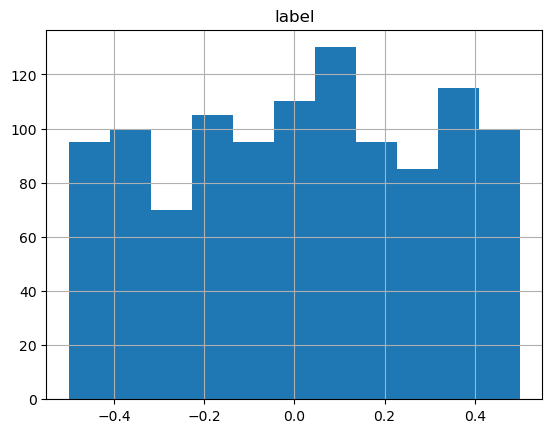

In [8]:
labels = df_meta['label']
unique_labels = pd.unique(labels)
num_unique_labels = np.size(unique_labels)
df_meta.hist('label',bins=num_unique_labels)

array([[<Axes: title={'center': 'speed'}>]], dtype=object)

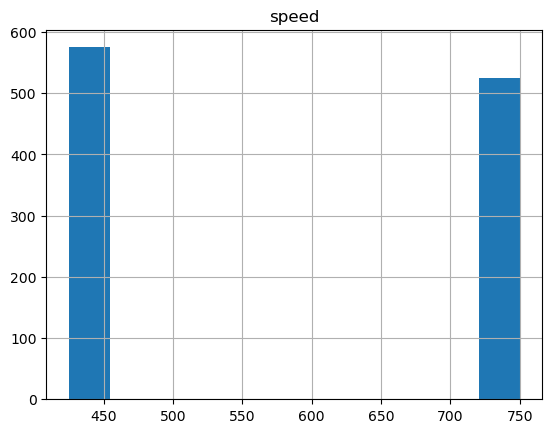

In [9]:
df_meta.hist('speed',bins=num_unique_labels)

[0.21033533 0.09352874] [ 50. 150.]
[0.20338835 0.09449777] [ 50. 150.]


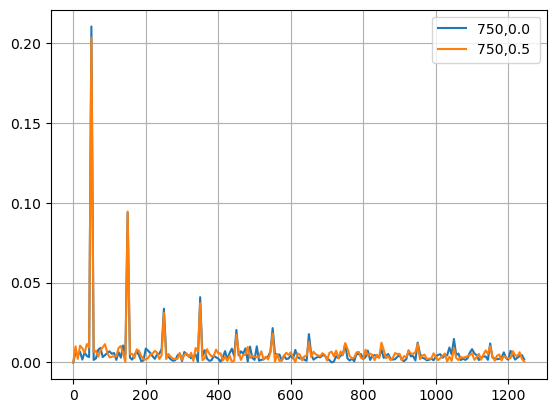

In [10]:
### I'm taking the fourier transform of the data and investegated it

DATAPATH = [f"train/train_{i}.csv" for i in df_meta["id"]] ###specifing the datapath for all the deferent samples

grouped_class = df_meta.groupby('group')['id'].apply(np.array) ###

fig, ax = plt.subplots(1)
# plt.setp(ax, xticks=np.arange(5, 15,1))
peaks = []
for i in range(0,6,5): #### for selecting the label
    peaks_group = []
    # for id in grouped_class[f'DAQ_{i+1}']:  ### for looking at all the sample with a certain label
    for e in range(1): ### for looking at a specific number of samples with a certain label
        id = random.choice(grouped_class[f'DAQ_{i+1}']) ### randomly select a sample within the label group
        while df_meta['speed'][id] != 750: ### In case you want to look at specific speeds
            id = random.choice(grouped_class[f'DAQ_{i+1}'])
        if df_meta['speed'][id] == 750: ### To look at specific speeds when looking at all samples of a label group
            
            #putting a datasample in a dataframe
            df = pd.read_csv(DATAPATH[id])
            
            
            
            # ax.plot(df.iloc[:,0],df[str(0)]/150, label = f"{df_meta['speed'][id]},{df_meta['label'][id]} ")
            # ax.plot(df.iloc[:,0],df[str(2)]-np.mean(df[str(2)]), label = f"{df_meta['speed'][id]},{df_meta['label'][id]} ")
            
            
            ### the real fourrier transform of the acceleration shifted to remove 0 frequency peak in the fourrier spectrum
            
            rft = np.abs(rfft(df[str(2)].values-np.mean(df[str(2)].values),n=2048)) 
                        
            ### window of intresting frequencies
            # res = []
            # for i in range(3):
            #     res.append(np.argwhere(freq>=750*(i+1)-3.2)[0,0])
            #     res.append(np.argwhere(freq>=425*(i+1)-3.2)[0,0])
            
            ##### frequencies of the spectrum
            freq = rfftfreq(2048,d=1/12800)
            
            ### peak detection on the spectrum
            indices = signal.find_peaks(np.real(rft),height=0.05)[0]

            ### plot of the spectrum
            # ax.plot(freq[indices],rft[indices], marker ='o',linestyle=' ',color = 'red', label = f"peak")
            ax.plot(freq[:200],rft[:200],label = f"{df_meta['speed'][id]},{df_meta['label'][id]} ")
            print(rft[indices],freq[indices])
            # ax.plot(freq[low_1:high_2],rft[low_1:high_2],label = f"{df_meta['speed'][id]},{df_meta['label'][id]} ")
            # ax.plot(freq[low_2:high_2],rft[low_2:high_2],label = f"{df_meta['speed'][id]},{df_meta['label'][id]} ")

            ### putting the values of intresting frequencies in a list to use in training
            # peaks_group.append(rft[res].tolist())
    peaks.append(peaks_group)
    
ax.grid(which='both')
plt.legend()
plt.show()

In [11]:
### attempt at taking the average of peak data
print("=============mean================")
means = []
for i in range(len(peaks)):
    means.append(np.mean(peaks[i],axis=0))
means = np.asanyarray(means)
print(means)

=============mean================
[nan nan]


C:\Users\tomva\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tomva\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


C:\Users\tomva\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\tomva\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\tomva\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\tomva\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


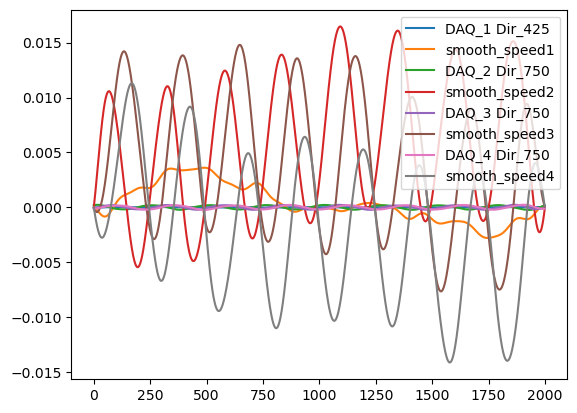

In [13]:
#### plot of data
for e in range(4):
    id = random.choice(grouped_class[f'DAQ_{e+1}'])
    df = pd.read_csv(DATAPATH[id])

    
    ### code to smoothen the data
    N = np.size(df[str(2)].values)
    rft = np.fft.fft(df[str(2)].values)
    # rft[-100:] = 0
    # rft[:100] = 0
    rft[20:-20] = 0
    # plt.plot(np.arange(np.size(rft)),rft)
    smooth = np.fft.ifft(rft, N)
    
    ### speed exctraction
    smooth -= np.mean(smooth)
    plt.plot(df.iloc[:,0],smooth,label=f"DAQ_{e+1} Dir_{df_meta['speed'][id]}")
    smooth_speed = np.real(integrate.cumulative_trapezoid(smooth, x = df.iloc[:,0]))
    plt.plot(df.iloc[1:,0],smooth_speed,label=f'smooth_speed{e+1}')

plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error

Mean absolute error:

sample 0
DAQ0: 0.8698835519515647DAQ1: 1.4344035573249183DAQ2: 0.47660860121557436
sample 1
DAQ0: 4.409213867811389DAQ1: 2.1017189781405348DAQ2: 6.889899927012409
sample 2
DAQ0: 9.78720319237772DAQ1: 5.993098942802951DAQ2: 6.970188735934786
sample 3
DAQ0: 1.947821227821267DAQ1: 5.377176203579662DAQ2: 1.8260534481624509

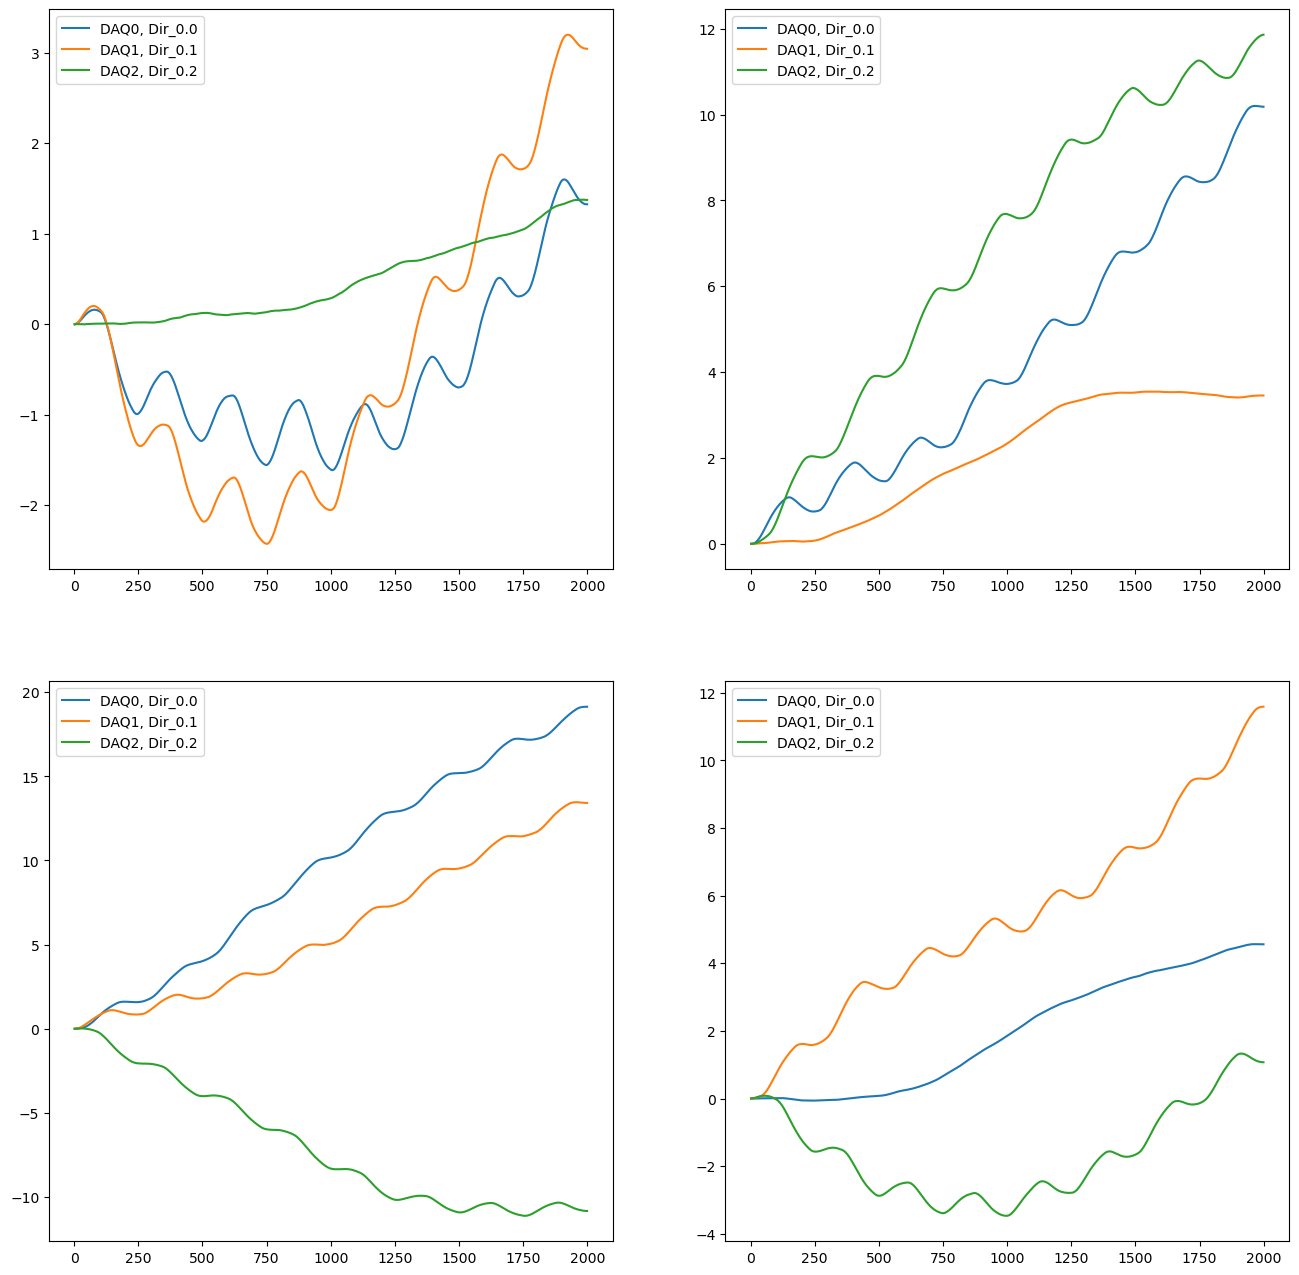

In [15]:
### speed and position extraction with plots

fig, ax = plt.subplots(2,2,figsize = (16,16))
print("Mean absolute error:")
for i in range(4):
    print(f"\nsample {i}")
    for e in range(3):
        
        id = random.choice(grouped_class[f'DAQ_{e+1}'])
        # while df_meta['speed'][id] == 425:
        #     id = random.choice(grouped_class[f'DAQ_{e+1}'])
            
        df = pd.read_csv(DATAPATH[id])
        
        N = np.size(df[str(2)].values)
        rft = np.fft.fft(df[str(2)].values)
        # rft[1:-1] = 0
        
        # rft[-100:] = 0
        # rft[:100] = 0
        smooth = np.real(np.fft.ifft(rft, N))
        smooth -= np.mean(smooth)
        
        # ax[i//2,i%2].plot(df.iloc[:,0],smooth,label=f'DAQ{e}')

        speed = np.real(integrate.cumulative_trapezoid(smooth, x = df.iloc[:,0]))
        position = np.real(integrate.cumulative_trapezoid(speed, x = df.iloc[1:,0]))
        ax[i//2,i%2].plot(df.iloc[2:,0],position,label=f"DAQ{e}, Dir_{df_meta['label'][id]}")
        ax[i//2,i%2].legend()
        print(f"DAQ{e}: {mean_absolute_error(np.zeros_like(position),position)}",end="")
plt.show()

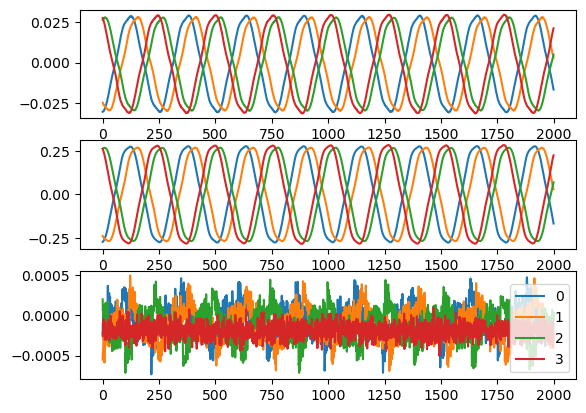

In [16]:
### some more plots of the data

df = []

df.append(pd.read_csv(DATAPATH[random.choice(grouped_class['DAQ_1'])]))
df.append(pd.read_csv(DATAPATH[random.choice(grouped_class['DAQ_2'])]))
df.append(pd.read_csv(DATAPATH[random.choice(grouped_class['DAQ_3'])]))
df.append(pd.read_csv(DATAPATH[random.choice(grouped_class['DAQ_4'])]))


fig, ax = plt.subplots(3,1)

for i in range(3):
    for e in range(4):
        ax[i].plot(df[e].iloc[:,0],df[e][str(i)],label = f"{e}")
plt.legend()
plt.show()

In [17]:
#### means of the data

for e in range(1,12):
    name = f'DAQ_{e}'
    mean = []
    for i in grouped_class[name]:
        mean.append(np.mean(pd.read_csv(DATAPATH[i])['2']))
    if e == 1:
        new_df = pd.DataFrame(data = mean , columns = [name])
    else:
        df = pd.DataFrame(data = mean, columns = [name])
        new_df = pd.concat([new_df,df], axis = 1)


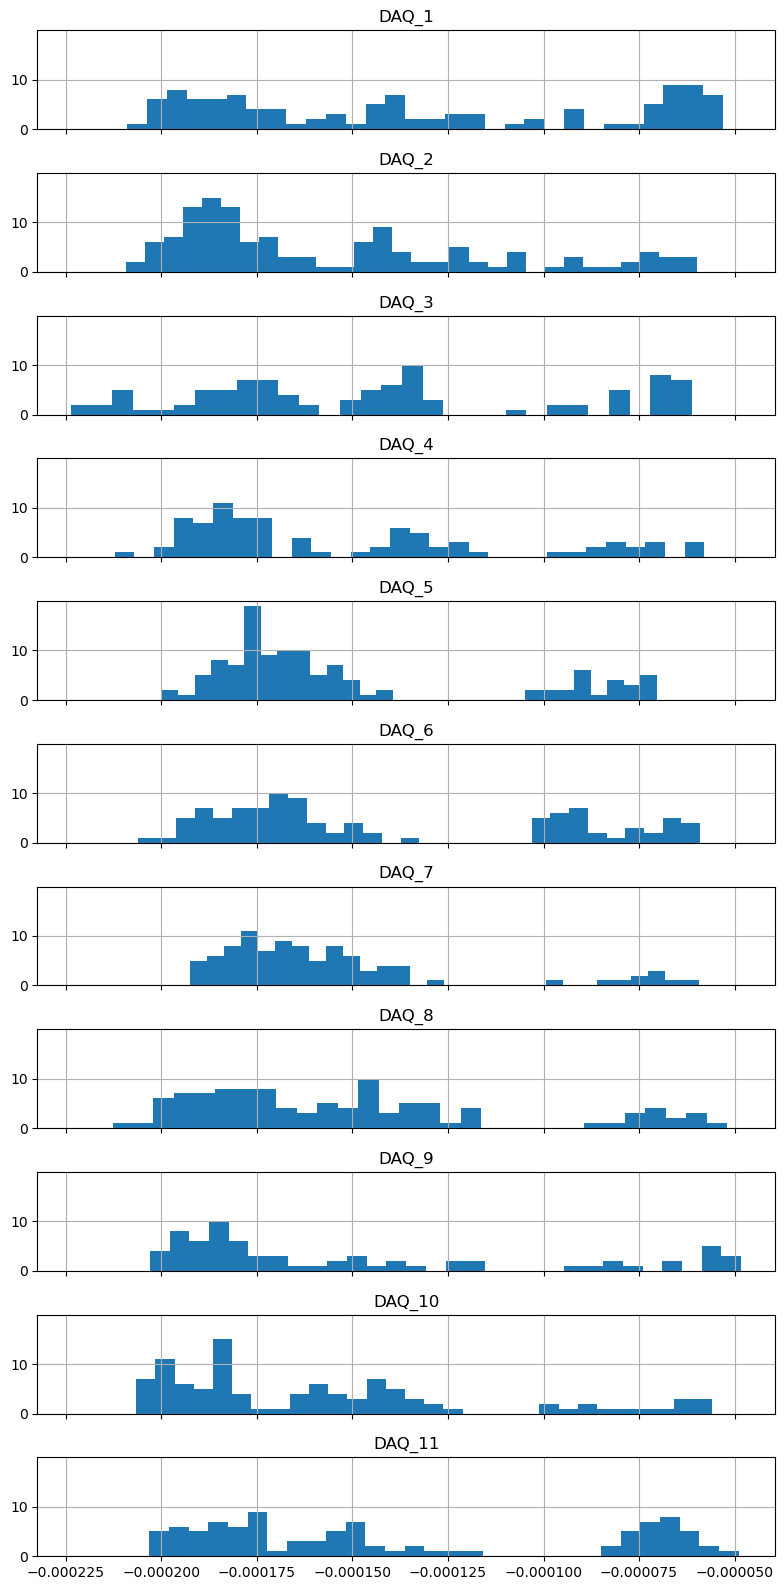

In [18]:
### histogram plot of the mean

fig, ax = plt.subplots(11,1,figsize=(8,16),sharex=True, sharey=True)
for i in range(1,12):
    new_df.hist(f'DAQ_{i}',bins=30,ax = ax[i-1])
    
fig.tight_layout()
plt.show()

In [19]:
### putting all the training data together

data = np.zeros((np.size(labels),1070))
df = pd.read_csv(DATAPATH[0])
print(np.shape(df))
for i in range(np.size(labels)):
    df = pd.read_csv(DATAPATH[i])

    speed = np.real(integrate.cumulative_trapezoid(df['2'], x = df.iloc[:,0]))
    position = np.real(integrate.cumulative_trapezoid(speed, x = df.iloc[1:,0]))
    df_speed = pd.DataFrame(np.transpose(speed))
    df_position = pd.DataFrame(np.transpose(position))
    
    rft = np.abs(rfft(df['2'].values-np.mean(df['2'].values),n=2048))

    dat = df.mean().iloc[1:].values
    dat = np.append(dat, df.var().iloc[1:].values)
    dat = np.append(dat, df.quantile(q=0.25).iloc[1:].values)
    dat = np.append(dat, df.quantile(q=0.50).iloc[1:].values)
    dat = np.append(dat, df.quantile(q=0.75).iloc[1:].values)
    dat = np.append(dat, df.skew().iloc[1:].values)
    dat = np.append(dat, df.min().iloc[1:].values)
    dat = np.append(dat, df.max().iloc[1:].values)
    dat = np.append(dat, df.kurtosis().iloc[1:].values)
    
    dat = np.append(dat, df_speed.mean().values)
    dat = np.append(dat, df_speed.var().values)
    dat = np.append(dat, df_speed.quantile(q=0.25).values)
    dat = np.append(dat, df_speed.quantile(q=0.50).values)
    dat = np.append(dat, df_speed.quantile(q=0.75).values)
    dat = np.append(dat, df_speed.skew().values)
    dat = np.append(dat, df_speed.min().values)
    dat = np.append(dat, df_speed.max().values)
    dat = np.append(dat, df_speed.kurtosis().values)
    
    dat = np.append(dat, df_position.mean().values)
    dat = np.append(dat, df_position.var().values)
    dat = np.append(dat, df_position.quantile(q=0.25).values)
    dat = np.append(dat, df_position.quantile(q=0.50).values)
    dat = np.append(dat, df_position.quantile(q=0.75).values)
    dat = np.append(dat, df_position.skew().values)
    dat = np.append(dat, df_position.min().values)
    dat = np.append(dat, df_position.max().values)
    dat = np.append(dat, df_position.kurtosis().values)
    dat = np.append(dat, rft)
    
    
    # dat = np.append(dat,df['0'].values)
    # dat = np.append(dat,df['1'].values)
    # dat = np.append(dat,df['2'].values)
    data[i] = dat
    



(2000, 4)


In [22]:
n_folds = 4
cv = KFold(n_splits=n_folds, shuffle=True, random_state = int(student_id))

I would suggest the groups to be the velocities and the classes the labels

A groups split isn't neccesarry since there are only 2 and they are quite well divided.

In [23]:
# # create the fixed pipeline:
# mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# preprocessing = Pipeline([('Scaler', PowerTransformer())])
# feature_selection = Pipeline([('selectkbest', SelectKBest())])  
# regressor = Pipeline([('reg', LinearRegression())])  # Use Ridge regression as an example

# task1pipe = Pipeline([
#     ('preprocessing', preprocessing),
#     ('feature_selection', feature_selection),
#     ('regressor', regressor)
# ])

# k_grid = [k for k in range(25, 45, 1)]
# # alpha_grid = np.logspace(0, 4, 10)  # Hyperparameters for Ridge regression

# param_grid = {
#     'feature_selection__selectkbest__k': k_grid,
#     # 'regressor__reg__alpha': alpha_grid,
# }

# # Define GridSearchCV object
# gridsearch = GridSearchCV(task1pipe, param_grid, scoring=mae_scorer,
#                           n_jobs=4, cv=cv, verbose=5, return_train_score=True)

In [24]:
# gridsearch.fit(data,df_meta['label'].values)

In [25]:
# results = gridsearch.cv_results_
# train_score = results['mean_train_score'][gridsearch.best_index_]
# validation_score = results['mean_test_score'][gridsearch.best_index_]
# print('Average training accuracy across folds: {:.3}'.format(train_score))
# print('Average validation accuracy across folds: {:.3}'.format(validation_score))

# print(gridsearch.best_params_)

In [29]:
# create the pipeline:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
train = []
val = []
par = []
k_grid = [k for k in np.arange(70,1070,100)]
alpha_grid = np.logspace(0, 4, 5)
feature_selection = Pipeline([('selectkbest', SelectKBest())])  
regressor = Pipeline([('reg', Ridge())])  # Use Ridge regression as an example

preprocessing = Pipeline([('Scaler', PowerTransformer())])

pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('regressor', regressor)
])


param_grid = {
    'feature_selection__selectkbest__k': k_grid,
    'regressor__reg__alpha': alpha_grid,
}

# Define GridSearchCV object
gridsearch = GridSearchCV(pipe, param_grid, scoring=mae_scorer,
                          n_jobs=4, cv=cv, verbose=5, return_train_score=True)

gridsearch.fit(data,df_meta['label'].values)
results = gridsearch.cv_results_
train.append(results['mean_train_score'][gridsearch.best_index_])
val.append(results['mean_test_score'][gridsearch.best_index_])
par.append(gridsearch.best_params_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


ValueError: 
All the 200 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 370, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 950, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 472, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 3144, in fit_transform
    return self._fit(X, y, force_transform=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 3176, in _fit
    self.lambdas_[i] = optim_function(col)
                       ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py", line 3365, in _yeo_johnson_optimize
    return optimize.brent(_neg_log_likelihood, brack=(-2, 2))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py", line 2641, in brent
    res = _minimize_scalar_brent(func, brack, args, **options)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py", line 2678, in _minimize_scalar_brent
    brent.optimize()
  File "C:\Users\tomva\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py", line 2448, in optimize
    xa, xb, xc, fa, fb, fc, funcalls = self.get_bracket_info()
                                       ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py", line 2417, in get_bracket_info
    xa, xb, xc, fa, fb, fc, funcalls = bracket(func, xa=brack[0],
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tomva\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py", line 3047, in bracket
    raise e
scipy.optimize._optimize.BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.


In [ ]:
for i in range(len(train)):
    print(f"preprocessor: {i}")
    print('Average training accuracy across folds: {:.3}'.format(train[i]))
    print('Average validation accuracy across folds: {:.3}'.format(val[i]))

    print(par[i])

In [ ]:
make_noise()